# 3D Molchanov

In [1]:
import logging

logging.basicConfig(level=logging.INFO)

logger = logging.getLogger(__name__)

In [2]:
from recognizer.utils.constants import ROOT_DIR, TARGET_TO_ENCODING
from recognizer.utils.utils import get_metadata_from_filename

DATASET_DIR_POSTA = ROOT_DIR / "data" / "all-20percent"

## Load Data

In [3]:
import os

import pandas as pd

targets = []
subjects = []
repetitions = []
files = []

for file in os.listdir(DATASET_DIR_POSTA):

    target, subject, repetition = get_metadata_from_filename(file)

    targets.append(target)
    subjects.append(subject)
    repetitions.append(repetition)
    files.append(str((DATASET_DIR_POSTA / file).resolve()))


metadata = pd.DataFrame(
    data={
        "target": targets,
        "subject": subjects,
        "repetition": repetitions,
        "file": files,
    }
)

metadata["target_encoding"] = metadata["target"].map(TARGET_TO_ENCODING)

metadata.head()

,target,subject,repetition,file,target_encoding
0,001,001,001,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
1,001,001,002,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
2,001,001,003,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
3,001,001,004,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0
4,001,001,005,C:\Users\facun\Desktop\DEV\ecd-trabajo-final\d...,0


### Train/Test split

In [4]:
import numpy as np

size = 1
replace = False
fn = lambda obj: obj.loc[np.random.choice(obj.index, size, replace),:]

testing_set = metadata.groupby(["target", "subject"], as_index=False).apply(fn)

testing_set.index = testing_set.index.droplevel(0)

training_set = metadata.loc[~metadata.index.isin(testing_set.index), :]

### Pre-processing functions

In [5]:
def transform(x):
    """Permutes the element to match the format expected by PyTorch: (C<channels>, T<frames>, H<height>, W<width>)"""
    # Transpose video from (T<frames>, H<height>, W<width>, C<channels>) to (C<channels>, T<frames>, H<height>, W<width>)
    return x.permute(3, 0, 1, 2).float()


### Datasets

In [6]:
BATCH_SIZE = 64
NUM_CLASSES = 64
NUM_FRAMES = 16
EPOCHS = 15
LR = 0.001

In [7]:
from recognizer.dataset import SampledVideoDataset

training_dataset = SampledVideoDataset(
    video_filenames=training_set["file"].values,
    labels=training_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)

testing_dataset = SampledVideoDataset(
    video_filenames=testing_set["file"].values,
    labels=testing_set["target_encoding"].values,
    num_frames=NUM_FRAMES,
    transform=transform,
)

print(f"Training/testing set: ({len(training_dataset)}, {len(testing_dataset)})")

Training/testing set: (2560, 640)


### Data Loaders

In [25]:
import torch 

from torch import nn

from recognizer.models.molchanov_3d import Molchanov3DCNN

# Las imágenes del video son de 192 x 108
# Hay 8 frames por video

# Es decir que cada elemento input será de 3x8x108x192 (C<channels> * T<frames> * H<height> * W<width>)

model = Molchanov3DCNN(
    num_classes=NUM_CLASSES,
    num_frames=NUM_FRAMES,
    batch_size=BATCH_SIZE,
)

train_loader = torch.utils.data.DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle = False)

test_loader = torch.utils.data.DataLoader(testing_dataset, batch_size=BATCH_SIZE, shuffle = False)

loss_function = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR)

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

model.to(device)

device

'cuda'

In [26]:
for n, p in model.named_parameters():
    print(f"Param: {n} | Shape: {p.shape}")

Param: conv_layer_1.0.weight | Shape: torch.Size([3, 3, 5, 5, 5])
Param: conv_layer_1.0.bias | Shape: torch.Size([3])
Param: conv_layer_2.0.weight | Shape: torch.Size([5, 3, 3, 3, 3])
Param: conv_layer_2.0.bias | Shape: torch.Size([5])
Param: fc_layer.0.weight | Shape: torch.Size([100, 48880])
Param: fc_layer.0.bias | Shape: torch.Size([100])
Param: fc_layer.3.weight | Shape: torch.Size([64, 100])
Param: fc_layer.3.bias | Shape: torch.Size([64])


## Training

In [27]:
import subprocess

CMD = '''
on run argv
  display notification (item 2 of argv) with title (item 1 of argv) sound name "Glass"
end run
'''

def notify(title, text):
    subprocess.call(['osascript', '-e', CMD, title, text])

In [28]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix
)

training_losses = []
testing_losses = []

accuracies = []
precisions = []
recalls = []
f1s = []
cm = None

In [29]:
print(
f"""
Beginning model training with parameters:
- Epochs: {EPOCHS}
- Batch Size: {BATCH_SIZE}
"""
)

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1} - Training")

    model.train()

    running_training_loss = 0.0

    for _, data in enumerate(train_loader):

        batch, labels = data[0].to(device), data[1].to(device)

        logits = model(batch)
        
        loss = loss_function(logits, labels)

        running_training_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_training_loss = running_training_loss / len(train_loader)
    training_losses.append(round(average_training_loss, 2))

    print(f"Epoch {epoch + 1} - AVG Training Loss: {average_training_loss:.2f}")

    # Evaluation
    print(f"Epoch {epoch + 1} - Evaluation")

    model.eval()

    all_preds = []
    all_targets = []

    running_testing_loss = 0.0

    with torch.no_grad():
        for data in test_loader:
            inputs, labels = data[0].to(device), data[1].to(device)

            print(f"Input: {inputs.shape} in device {inputs.device}; Labels: {labels.shape} in device {labels.device}")

            logits = model(inputs)

            _, preds = torch.max(logits, 1)

            all_preds.extend(preds.detach().cpu())
            all_targets.extend(labels.detach().cpu())

            loss = loss_function(logits, labels)
            running_testing_loss += loss.item()

    average_testing_loss = running_testing_loss / len(test_loader)
    testing_losses.append(round(average_testing_loss, 2))

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    accuracy = accuracy_score(all_targets, all_preds)
    precision = precision_score(all_targets, all_preds, average="macro")
    recall = recall_score(all_targets, all_preds, average="macro")
    f1 = f1_score(all_targets, all_preds, average="macro")

    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    if epoch == EPOCHS - 1:
        cm = confusion_matrix(all_targets, all_preds)

    print(f"""
    Epoch {epoch + 1} - Evaluation metrics
        - Accuracy  : {accuracy}
        - Precision : {precision}
        - Recall    : {recall}
        - F1        : {f1}
    """)



Beginning model training with parameters:
- Epochs: 15
- Batch Size: 64

Epoch 1 - Training


Epoch 1 - AVG Training Loss: 12.60
Epoch 1 - Evaluation
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 

c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



    Epoch 1 - Evaluation metrics
        - Accuracy  : 0.021875
        - Precision : 0.0017906235268133884
        - Recall    : 0.021875
        - F1        : 0.0030079191901199384
    
Epoch 2 - Training
Epoch 2 - AVG Training Loss: 4.16
Epoch 2 - Evaluation
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 

c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



    Epoch 2 - Evaluation metrics
        - Accuracy  : 0.0234375
        - Precision : 0.028183715624115986
        - Recall    : 0.0234375
        - F1        : 0.010320603582919731
    
Epoch 3 - Training
Epoch 3 - AVG Training Loss: 4.14
Epoch 3 - Evaluation
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 

c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



    Epoch 3 - Evaluation metrics
        - Accuracy  : 0.0390625
        - Precision : 0.018121085804255983
        - Recall    : 0.0390625
        - F1        : 0.018721410736817882
    
Epoch 4 - Training
Epoch 4 - AVG Training Loss: 4.11
Epoch 4 - Evaluation
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 

c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



    Epoch 4 - Evaluation metrics
        - Accuracy  : 0.0421875
        - Precision : 0.06809078409407357
        - Recall    : 0.042187499999999996
        - F1        : 0.02548305863934688
    
Epoch 5 - Training
Epoch 5 - AVG Training Loss: 4.02
Epoch 5 - Evaluation
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64

c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



    Epoch 5 - Evaluation metrics
        - Accuracy  : 0.0734375
        - Precision : 0.12136637793468148
        - Recall    : 0.07343749999999999
        - F1        : 0.05295558895982033
    
Epoch 6 - Training
Epoch 6 - AVG Training Loss: 3.79
Epoch 6 - Evaluation
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64,

c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



    Epoch 6 - Evaluation metrics
        - Accuracy  : 0.1921875
        - Precision : 0.2852256595953442
        - Recall    : 0.1921875
        - F1        : 0.17322453173594546
    
Epoch 7 - Training
Epoch 7 - AVG Training Loss: 3.45
Epoch 7 - Evaluation
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216

c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



    Epoch 7 - Evaluation metrics
        - Accuracy  : 0.309375
        - Precision : 0.365177528557253
        - Recall    : 0.309375
        - F1        : 0.28040639981586807
    
Epoch 8 - Training
Epoch 8 - AVG Training Loss: 3.02
Epoch 8 - Evaluation
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 3

c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



    Epoch 8 - Evaluation metrics
        - Accuracy  : 0.4234375
        - Precision : 0.4884611909899448
        - Recall    : 0.4234375
        - F1        : 0.40437249237994877
    
Epoch 9 - Training
Epoch 9 - AVG Training Loss: 2.48
Epoch 9 - Evaluation
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216

c:\Users\facun\AppData\Local\pypoetry\Cache\virtualenvs\recognizer-U-rlUTHu-py3.10\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



    Epoch 9 - Evaluation metrics
        - Accuracy  : 0.5328125
        - Precision : 0.6282872314787465
        - Recall    : 0.5328124999999999
        - F1        : 0.5300902649076702
    
Epoch 10 - Training
Epoch 10 - AVG Training Loss: 1.98
Epoch 10 - Evaluation
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64, 3, 16, 216, 384]) in device cuda:0; Labels: torch.Size([64]) in device cuda:0
Input: torch.Size([64,

## Evaluation

### Confusion Matrix

In [30]:
cm = confusion_matrix(all_targets, all_preds)

Text(70.72222222222221, 0.5, 'Class')

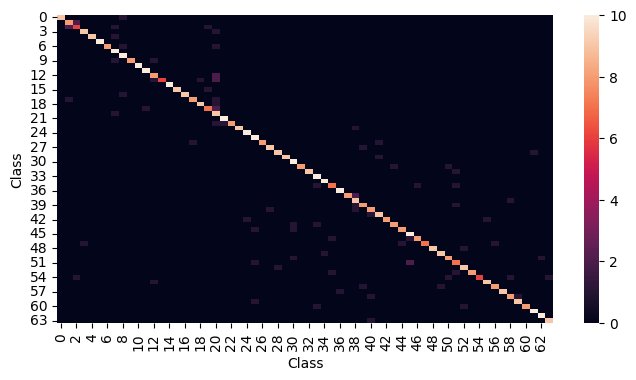

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

sns.heatmap(data=cm, ax=ax)

ax.
ax.set_xlabel("Class")
ax.set_ylabel("Class")

### Accuracy/Recall/Precision

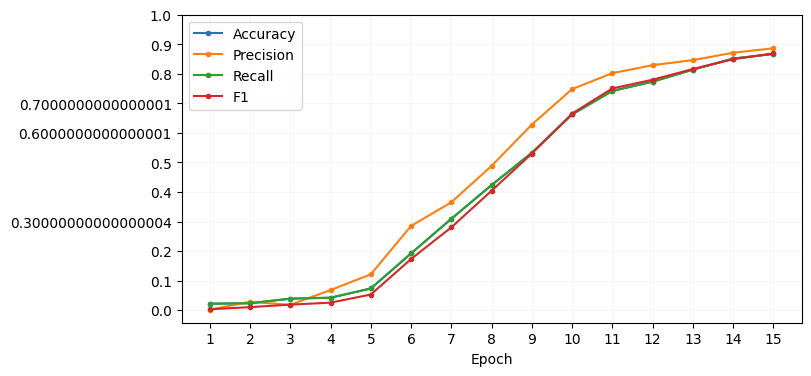

In [32]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(accuracies, label="Accuracy", marker=".")
ax.plot(precisions, label="Precision", marker=".")
ax.plot(recalls, label="Recall", marker=".")
ax.plot(f1s, label="F1", marker=".")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_yticks(np.arange(0, 1.1, 0.1))
ax.set_yticklabels(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

### Loss

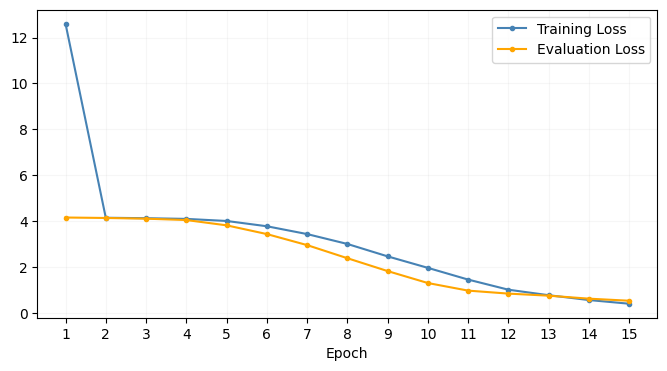

In [33]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.plot(training_losses, label="Training Loss", marker=".", color="steelblue")
ax.plot(testing_losses, label="Evaluation Loss", marker=".", color="orange")

ax.set_xticks(range(0, epoch+1))
ax.set_xticklabels(range(1, epoch+2))
ax.set_xlabel("Epoch")
ax.legend()
ax.grid(alpha=0.1)
plt.show()

## Save model

In [35]:
from recognizer.utils.constants import ROOT_DIR

MODELS_DIR = ROOT_DIR / "models"

MODEL_PATH = MODELS_DIR / "molchanov_3d_01.pth"

with open(MODEL_PATH, "w") as f:
        f.write("")

torch.save(model, f=MODEL_PATH)